# CSCI 3352 Biological Networks, Spring 2021, Prof. Clauset
Submit here: https://canvas.colorado.edu/courses/69236

# Problem Set 5 : Predicting missing links in networks

***

**Name**: Clayton Schneider

***

This assignment is due on Canvas by **11:55pm on Friday, February 19th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 102 points total, and 37 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Canvas.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [239]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd



***
## Problem 1 : Warm up (10 pts total)

For the network $G_\circ$ given below, calculate by hand and report the `Jaccard coefficient` and `degree product` score values for the following pairs of nodes:
* $i=1$ and $j=4$
* $i=1$ and $j=5$
* $i=4$ and $j=9$
* $i=9$ and $j=2$

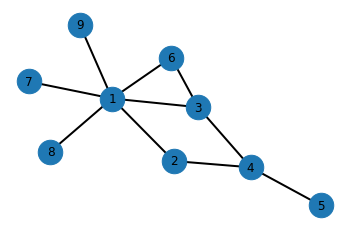

In [240]:
Go = nx.Graph([(1,2),(1,3),(1,6),(1,7),(1,8),(1,9),(3,4),(3,6),(4,5),(4,2)]) # observed graph Go

nx.draw_networkx(Go,with_labels=True,node_size=600,width=2) # draw it pretty
limits=plt.axis('off')                                      # turn off axes
plt.show() 

* $J(1,4)=\frac{2}{7}$, $D(1,4)=18$
* $J(1,5)=0$, $D(1,5)=6$
* $J(4,9)=0$, $D(4,9)=3$
* $J(9,2)=\frac{1}{2}$, $D(9,2)=2$

***
## Problem 2 : Where did all the links go? (92 pts total)

In this problem, you will implement and systematically evaluate the `baseline`, `Jaccard coefficient` and `degree product` predictors for missing links. As with the missing attribute prediction in PS4, we'll build up this numerical experiment in stages.
* First, you'll implement the `baseline`, `Jaccard coefficient`, and `degree product` score functions.
* Then, you'll construct an ROC curve and compute its AUC using synthetic data.
* After that, you'll construct a *good* test of the 3 link predictors for a single level of _missingness_ $\alpha$. 
* And finally, you'll write a wrapper around this function to explore how performance varies as a function of $\alpha$.

For the last two steps, we'll again use a real-world network derived from the genes of the human malaria parasite _P. falciparum_. These genes are located in one of nine highly variable regions (HVRs) in the DBLa domain of the parasite's var protein. In this network, nodes are antigen *genes* of the parasite and two nodes are connected if they contain evidence of past non-homologous *recombination* (basically, if they share a long subsequence).
* Visit the [Index of Complex Networks](https://icon.colorado.edu/) and obtain the `HVR_1` network via the ICON entry _Malaria var DBLa HVR networks_.

### Problem 2-A (12 pts) : baseline, Jaccard, and degree product score functions

* Write 3 seperate functions to implement the `predictor_Baseline()`, `predictor_Jaccard()`, and `predictor_DegreeProd()` score functions, as described in Lecture Notes 4. Function interfaces are given below.
* Then write a function `apply_Predictors(G,Y)`, which applies the three predictors to a given simple network `G` with list of missing links `Y`. This function should
  * first obtain the list of candidate pairs (non-edges in `G`, defined as `X` in the Lecture Notes),
  * for each such pair, apply the 3 predictors, and
  * store the results in a way that allows you to output a table of the form shown in Lecture Notes 4, with columns `i,j,tau,score_baseline,score_Jaccard,score_DegreePred`
* Then,
  * run your function on the $G_\circ$ given below
  * sort the rows of the output table by the `score_Jaccard` column, and 
  * write out the sorted table in the form `{i},{j} : {tau} : {baseline}  {jaccard}  {degree prod}`

Hint 1: `networkx` has two built-in functions that may be useful: `jaccard_coefficient()` and `preferential_attachment()`, but note that you will need to write a wrapper around each in order to make them break ties randomly the way we defined in the lecture notes. Also, be warned: these functions return a 'generator'.

Hint 2a: I found it useful to have `apply_Predictors(G,Y)` return its results as a 2d numpy array, where the first 2 columns are $i,j$, the 3rd column is the $\tau$ value indicating if $i,j$ is a missing edge or not, and the last 3 columns give the baseline, jaccard, and degree product scores in that order. This made it straightforward to then sort the rows by the jaccard score, using the `.argsort()` function. You're free to use whatever data structure you want.

Hint 2b: I also found it useful to implement a helper function `get_candidateEdges(G)` that took as input `G` and returned as output `X`, the list of non-edges in `G`, which my `apply_Predictors(G,Y)` function calls.

In [241]:
def predictor_Baseline():
    # implements the baseline link predictor
    # input : none, because its output is independent of G
    # output: score(i,j) = r where r = Uniform(0,1)
    
    ####################################
    ##### do not modify above here #####

    return float(np.random.uniform(size=1))


In [242]:
def predictor_Jaccard(Gx,i,j):
    # implements the Jaccard coefficient link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = Jaccard(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    ####################################
    ##### do not modify above here #####

    i_neighbors = list(Gx.neighbors(i))
    j_neighbors = list(Gx.neighbors(j))
    
    intersect = [nabo for nabo in i_neighbors if nabo in j_neighbors]
    union = []
    for n in i_neighbors:
        union.append(n)
    for n in j_neighbors:
        union.append(n)
    union = list(set(union))
    
    return float((len(intersect) / (len(union) + 1e-5)) + np.random.uniform(low=-1e-5, high=1e-5, size=1))

#     return list(nx.jaccard_coefficient(Gx, [(i, j)]))[0][0] + np.random.uniform(low=-1e-5, high=1e-5, size=1)

In [243]:
def predictor_DegreeProd(Gx,i,j):
    # implements the baseline link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = DegreeProduct(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    ####################################
    ##### do not modify above here #####

    return float((Gx.degree(i) * Gx.degree(j)) + np.random.uniform(low=-1e-5, high=1e-5, size=1))


In [244]:
def apply_Predictors(G,Y):
    # input : G, a networkx simple graph
    #         Y, list of missing links in G
    # output: S, table of the form [ i | j | tau | baseline | jaccard | degree product ]

    ####################################
    ##### do not modify above here #####
    dataset = []
    
    non_edges = list(nx.non_edges(G))
    for edge in Y:
        non_edges.append(edge)

    for (i, j) in non_edges:
        dataset.append([
            i,
            j,
            1 if (i, j) in missing else 0,
            predictor_Baseline(),
            predictor_Jaccard(G, i, j),
            predictor_DegreeProd(G, i, j)])
        
    return np.array(dataset)

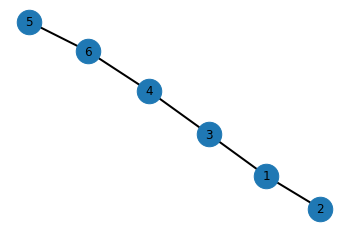

['i', 'j', 'tau', 'score_baseline', 'score_Jaccard', 'degree_Pred']
2.0 3.0 : 1.0 : 0.0014625205766672922 : 0.5000053616510675 : 1.999990740442077
4.0 5.0 : 1.0 : 0.15687238049082364 : 0.5000039197396559 : 1.9999962800938442
2.0 3.0 : 1.0 : 0.01689750862418249 : 0.49999641542971635 : 1.9999987520119196
4.0 5.0 : 1.0 : 0.6870812608134097 : 0.49999053387117803 : 1.9999964718412877
3.0 6.0 : 0.0 : 0.7291731222894293 : 0.33333959640890276 : 3.999990735977614
1.0 4.0 : 0.0 : 0.7134859474397159 : 0.3333379356154869 : 4.000005700358583
2.0 5.0 : 0.0 : 0.6345830172750032 : 8.99895605201812e-06 : 0.9999931157183378
1.0 6.0 : 0.0 : 0.5865697492904828 : 8.747114169059939e-06 : 4.000008347955342
3.0 5.0 : 0.0 : 0.9947441623083236 : 2.14175248885778e-06 : 1.999999023638633
2.0 6.0 : 0.0 : 0.8927017236488117 : 1.1431090791021493e-06 : 2.000006074878631
1.0 5.0 : 0.0 : 0.5657319171312697 : -8.385449354466334e-06 : 1.9999958810255096
2.0 4.0 : 0.0 : 0.4137314303653591 : -9.628418865481986e-06 : 1.9999

In [245]:
Go      = nx.Graph([(1,2),(1,3),(3,4),(5,6),(4,6)]) # observed graph Go, from Lecture 4
missing = [(2,3),(4,5)]                             # list of edges missing from Go

nx.draw_networkx(Go,with_labels=True,node_size=600,width=2) # draw it pretty
limits=plt.axis('off')                                                             # turn off axes
plt.show() 

####################################
##### do not modify above here #####

columns = ['i', 'j', 'tau', 'score_baseline', 'score_Jaccard', 'degree_Pred']
print(columns)

results = apply_Predictors(Go, missing)

sortedResults = results[results[:,4].argsort()[::-1]]

for row in sortedResults:
    print(
        row[0], row[1],
        ':',
        row[2],
        ':',
        row[3],
        ':',
        row[4],
        ':',
        row[5]
    )

### Problem 2-B (20 pts) : ROC that curve and AUC

* Write a function `tabulate_TPR_FPR(S)` that extends the basic score table from `Problem 2-A` to include columns for TPR and FPR values, as described in Lecture Notes 4.
* Then write a function `calculate_AUC(TPR,FPR)` that takes as input the TPR and FPR columns of your table, and computes the AUC.
* Finally, for each of the three predictors `baseline`, `Jaccard`, and `degree product`, apply your functions to
  * compute the TPR and FPR values, and use them to plot a ROC curve (include a $y=x$ reference line)
  * *2 pts extra credit* if you plot the three ROC curves on a single plot,
  * compute and report the AUC values for each predictor (be sure to label which is which), and
  * then comment briefly on the ROC curves, AUC values, and which predictor is better for this graph `Go`.

Hint 1: After tabulating the TPR and FPR columns, don't forget to prepend a row for (TPR=0,FPR=0) before you make the ROC plot or compute the AUC.

Hint 2: However you decided to store the table will determine how you write these two functions. In my solutions, `S` is a 2d numpy array.

In [246]:
def tabulate_TPR_FPR(S):
    # see Lecture Notes 4
    # input : a data structure S containing a table whose rows have the form:
    #         [ i j tau score(i,j) ]
    #        sorted in descending order of score(i,j)
    # output: a data structure T containing a table whose rows have the form:
    #         [ i j tau TPR FPR score(i,j) ]
    #        sorted descending in score(i,j)

    ####################################
    ##### do not modify above here #####

    # add new columns
    S = np.insert(S, 3, 0, axis=1)
    S = np.insert(S, 3, 0, axis=1)
    
    # OH MY GOD I HAD A TYPO HERE \/ FOR THE LONGEST TIME IT WAS SO FRUSTRATING
    # I HAD S[:2] INSTEAD OF S[:, 2]    :(
    # I HAD NEGATIVE VALUES FOR FPR WOW THAT WAS DUMB GLAD I FINALLY FOUND IT
    # WISH I KNEW HOW TO READ
    # THANKS, GRADER PEOPLE, YOUR FEEDBACK IS SO HELPFUL
    total_pos = np.sum(S[:,2])
    total_neg = len(S) - total_pos
    
    ell = len(S)
    
    taus = 0
    n_taus = 0
    k = 0
    while k in range(ell):
        taus += S[k, 2]
        if total_pos != 0:
            TPR = taus / total_pos
        else:
            TPR = 0
        n_taus += (1 - S[k, 2])
        if total_neg != 0:
            FPR = n_taus / total_neg
        else:
            FPR = 0
        S[k, 3] = TPR
        S[k, 4] = FPR
        
        k += 1
    
    return S

In [247]:
def calculate_AUC(TPR,FPR):
    # see Lecture Notes 4
    # input : the TPR and FPR columns of your table (which have equal length and where TPR[0]=FPR[0]=0)
    # output: the AUC, a scalar on the unit interval

    ####################################
    ##### do not modify above here #####

    AUC = 0
    
    for i, (tp, fp) in enumerate(zip(TPR, FPR)):
        if i == 0:
            continue
        AUC += tp*(fp - FPR[i-1])
        
    return AUC

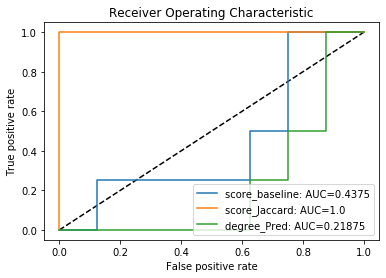

In [248]:
### YOUR CODE HERE
columns = ['i', 'j', 'tau', 'score_baseline', 'score_Jaccard', 'degree_Pred']
# print(columns)

results = apply_Predictors(Go, missing)

fig1 = plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic')

for score in ['score_baseline', 'score_Jaccard', 'degree_Pred']:
    j = columns.index(score)
    sortedResults = results[results[:,j].argsort()[::-1]]
    sortedResults = np.delete(sortedResults, [k for k in range(len(sortedResults.T)) if ((k >= 3) and (k != j))], axis=1)

    S = tabulate_TPR_FPR(sortedResults)
    TPR = S[:, 3]
    TPR = np.insert(TPR, 0, 0)
    FPR = S[:, 4]
    FPR = np.insert(FPR, 0, 0)
    
    AUC = calculate_AUC(TPR, FPR)
    
    plt.plot(FPR, TPR, label='{}: AUC={}'.format(score, AUC))
    
plt.legend()

Wowee I almost did this wrong... I didn't add any actual "non-edges", and was only using missing... Was really confused about why you wanted us to keep getting AUC=0. 

In this graph, the jaccard coefficient performs perfectly, while the other two perform ~< chance. 

### Problem 2-C (10 pts)

To warm up, load the *HVR_1* network and treat it as a simple graph (edges unweighted and undirected; no multi-edges; no self-loops). Then calculate and report the following.
* number of nodes $n$
* (undirected) edges $m$
* mean degree $\langle k \rangle$
* clustering coefficient $C$
* mean geodesic distance $\langle \ell \rangle$
* the CCDF of the degree distribution (use `plot_CCDF(kis)` from `Problem Set 3`)
* a `ridiculogram` of the network, using a spring layout

In [249]:
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

reading the network file : HVR_1.txt

number of nodes, n  = 307
number of edges, m  = 2812
mean degree,    <k> = 86.16
clustering coefficient, C     =  0.59
mean geodesic distance, <ell> =  3.52


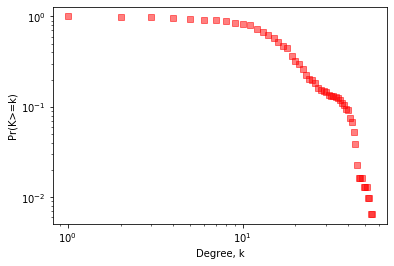

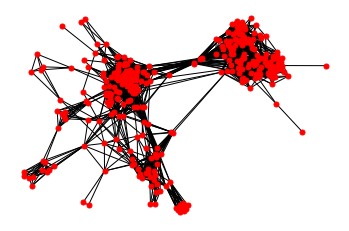

In [250]:
# this data set is from :
# D. B. Larremore et al., "A network approach to analyzing highly recombinant malaria parasite genes."
#                          PLOS Computational Biology 9(10), e1003268 (2013).
fname1 = 'HVR_1.txt'

# read in the network file (an edge list)
print(f'reading the network file : {fname1}\n')
G = nx.read_edgelist('./' + fname1, delimiter=',', nodetype=int)  # import as a simple graph, index nodes by integers (not strings)

####################################
##### do not modify above here #####

n = len(G.nodes())
m = len(G.edges())
kmean = np.mean(G.degree())
C = nx.transitivity(G)
ellmean = nx.average_shortest_path_length(G)

##### do not modify below here #####
####################################

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

plot_CCDF([k[1] for k in G.degree])
nx.draw_networkx(G,with_labels=False,node_size=25,node_color='r',width=1) # default: spring embed, with some options
limits=plt.axis('off')  # turn off the bounding box and axis labels
plt.show()              # show me the network!

### Problem 2-D (30 pts) : a good measurement, once

Now we get to play with malaria gene data. Define the edge missingness function $f$ to be one that selects a uniformly random _fraction_ $\alpha$ of edges in $G$ to observe in $G_\circ$.

Because $f$ is a stochastic function, the AUC we calculate will be a random variable, and we will need to average the AUC over several _repetitions_ to get a good estimate.

* Set `nrep=3` and $\alpha=0.8$, and let each edge $(i,j)\in G$ be observed in $G_\circ$ with probability $\alpha$.
* For each repetition, create a new $G_\circ$, apply all 3 predictors to its set of non-edges, compute and store the AUCs for each predictor
* In each repetition, write out its results like `[rep=0] baseline AUC = {a}   Jaccard AUC = {b}   degprod AUC = {c}`
* In the *first* repetition only, output a plot of the ROC curves (all on one figure) of the 3 predictors.
* Finally, briefly comment about any confirmations or surprises you see in the ROC plot or the AUC results, for each of the predictors, *and* what the relative performance of `Jaccard` vs. `degree product` says about the structure of the network. Refer back to the summary statistics you found in `2-C` to justify your comments.

Hint 1: you might be tempted to use the `.copy` functionality in `networkx` or to try a straight assignment `Go=G`. I recommend not doing this, because both are *shallow* copies. Instead, start with a new empty graph like `Go = nx.Graph()` and then iterate through `G.edges()`, using `Go.add_edges_from()` to add each observed edge one at a time.

Hint 2: you can check that your code is about right by trying a few different values of $\alpha$. When I ran it with $\alpha=0.1$, I found the Jaccard AUC $\approx0.6$, and with $\alpha=0.95$, I found degree product AUC $\approx0.7$. It makes sense that AUC should increase with $\alpha$, since at higher values, we're making fewer predictions and have more observed edges to work with.

[rep=0] baseline AUC=0.0 Jaccard AUC=0.0 degprod AUC=0.0
[rep=1] baseline AUC=0.0 Jaccard AUC=0.0 degprod AUC=0.0
[rep=2] baseline AUC=0.0 Jaccard AUC=0.0 degprod AUC=0.0


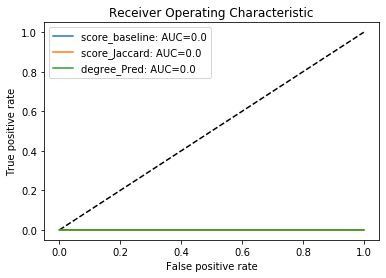

In [254]:
import random as rnd
seed = 698 # your MMYY birthday here
rnd.seed(seed)

nreps = 3     # number of repetitions to average over
alpha = 0.80  # fraction of edges to observe

AUCs_base = [] # for storing list of nreps AUCs from baseline
AUCs_jacc = [] # for storing list of nreps AUCs from jaccard
AUCs_degp = [] # for storing list of nreps AUCs from degree product

####################################
##### do not modify above here #####

for i in range(nreps):
    Go = G
    missing = []
    safe_edges = np.random.uniform(size=len(G.edges))
    
    # remove 1-alpha sample of edges from G
    # and add them to non_edges
    for p, edge in enumerate(Go.edges()):
        if safe_edges[p] > alpha:
            Go.remove_edge(edge[0], edge[1])
            missing.append(edge)
            
    columns = ['i', 'j', 'tau', 'score_baseline', 'score_Jaccard', 'degree_Pred']
    # print(columns)

    results = apply_Predictors(Go, missing)
    
    if i == 0:
        fig1 = plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('Receiver Operating Characteristic')

    for score in ['score_baseline', 'score_Jaccard', 'degree_Pred']:
        j = columns.index(score)
        sortedResults = results[results[:,j].argsort()[::-1]]
        sortedResults = np.delete(sortedResults, [k for k in range(len(sortedResults.T)) if ((k >= 3) and (k != j))], axis=1)

        S = tabulate_TPR_FPR(sortedResults)
        TPR = S[:, 3]
        TPR = np.insert(TPR, 0, 0)
        FPR = S[:, 4]
        FPR = np.insert(FPR, 0, 0)

        AUC = calculate_AUC(TPR, FPR)
        if score == 'score_baseline':
            AUCs_base.append(AUC)
        elif score == 'score_Jaccard':
            AUCs_jacc.append(AUC)
        elif score == 'degree_Pred':
            AUCs_degp.append(AUC)
        else:
            raise ValueError

        if i == 0:
            plt.plot(FPR, TPR, label='{}: AUC={}'.format(score, AUC))
            plt.legend()
            
    print('[rep={}] baseline AUC={} Jaccard AUC={} degprod AUC={}'.format(i, AUCs_base[i], AUCs_jacc[i], AUCs_degp[i]))

Again, the jaccard coefficient performs the best. I believe that the poor performance of the degree product predictor means that we really can't rely on that in this graph. I suppose if we could, it would mean that it was non-assortative, whereas this graph most likely is. 

### Problem 2-E (20 pts) Putting it all together

Using the code you wrote for `Problem 2-D` as the core, now write a wrapper that allows you to perform the full numerical experiment to investigate how the 3 link predictors perform as a function of how much of the network is observed. Here, you'll conduct the experiment, record the results, and present them in a nice plot.

* Write the wrapper around your `Problem 2-D` code to measure how the mean AUC for each link predictor varies a function of $\alpha$ on the malaria gene network.

* Produce a single `plot` showing all 3 functions, for $\alpha=\{0.1, 0.3, 0.5, 0.7, 0.9\}$ and `nreps=5` (try a smaller number to see how much roughness you're smoothing over).
* (*Extra credit 5pts*: use at least 10 evenly-spaced increments of $\alpha$ between 0 and 1.)

* Then, briefly discuss what you see about how the AUC varies by link predictor with $\alpha$. What trends do you see? Do they go in the direction you would expect? Does anything interesting happen at intermediate values of $\alpha$? Try to give some intuition as to why this behavior makes sense given what we know about what structures each link predictor exploits, the structural patterns revealed by the summary statistics you calculated in `Problem 2-C`, and what effect different values of $\alpha$ have on $G_\circ$.

Hint: As in PS4, a key part of such a numerical experiment is storing the intermediate results. For each choice of $\alpha$, the core code from `Problem 2-D` will produce three AUCs; I stored these, along with $\alpha$, in a single 4-column numpy array. It was then straightforward to plot each of columns 2,3,4 vs. column 1 to make the target plot. As in PS4, I also found it useful to separate the code for the experiment from the code for the visualization, so that I could tinker with the latter without having to re-run the former. On my laptop, it took less than 2 minutes for 5 repetitions, per value of $\alpha$.

In [252]:
import random as rnd
seed = 698 # your MMYY birthday here
rnd.seed(seed)

nreps = 5     # number of repetitions to average over
alphas = np.linspace(0, 1, num=10)  # fraction of edges to observe

base_means = []
jacc_means = []
degp_means = []

for alpha in alphas:
    AUCs_base = [] # for storing list of nreps AUCs from baseline
    AUCs_jacc = [] # for storing list of nreps AUCs from jaccard
    AUCs_degp = [] # for storing list of nreps AUCs from degree product

    ####################################
    ##### do not modify above here #####

    for i in range(nreps):
        Go = G
        missing = []
        safe_edges = np.random.uniform(size=len(G.edges))

        # remove 1-alpha sample of edges from G
        # and add them to non_edges
        for p, edge in enumerate(Go.edges()):
            if safe_edges[p] > alpha:
                Go.remove_edge(edge[0], edge[1])
                missing.append(edge)

        columns = ['i', 'j', 'tau', 'score_baseline', 'score_Jaccard', 'degree_Pred']
        # print(columns)

        results = apply_Predictors(Go, missing)

        for score in ['score_baseline', 'score_Jaccard', 'degree_Pred']:
            j = columns.index(score)
            sortedResults = results[results[:,j].argsort()[::-1]]
            sortedResults = np.delete(sortedResults, [k for k in range(len(sortedResults.T)) if ((k >= 3) and (k != j))], axis=1)

            S = tabulate_TPR_FPR(sortedResults)
            TPR = S[:, 3]
            TPR = np.insert(TPR, 0, 0)
            FPR = S[:, 4]
            FPR = np.insert(FPR, 0, 0)

            AUC = calculate_AUC(TPR, FPR)
            if score == 'score_baseline':
                AUCs_base.append(AUC)
            elif score == 'score_Jaccard':
                AUCs_jacc.append(AUC)
            elif score == 'degree_Pred':
                AUCs_degp.append(AUC)
            else:
                raise ValueError
                
    base_means.append(np.mean(AUCs_base))
    jacc_means.append(np.mean(AUCs_jacc))
    degp_means.append(np.mean(AUCs_degp))

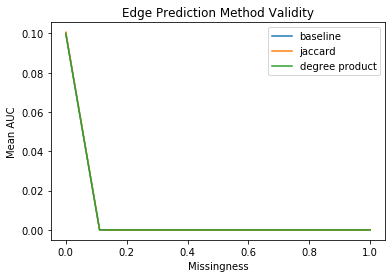

In [253]:
# YOUR PLOTTING CODE HERE (so your simulation doesn't need to re-run just to tinker with how the plots look)
fig1 = plt.figure(1)
plt.xlabel('Missingness')
plt.ylabel('Mean AUC')
plt.title('Edge Prediction Method Validity')

plt.plot(alphas, base_means, label='baseline')
plt.plot(alphas, jacc_means, label='jaccard')
plt.plot(alphas, degp_means, label='degree product')

plt.legend()

Your discussion here

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
Give the Authors, Title, Publication Venue, Year
<br/>

* *What was the research question?*<br/>
Your answer here
<br/>

* *What was the approach the authors took to answer that question?*<br/>
Your answer here
<br/>

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here

***
***

## Problem 4 : Index of Complex Networks (*10 pts extra credit*)

The *Index of Complex Networks* (ICON) is the largest index of real-world complex network data sets available. It's not a repository, and instead lists network data sets that can be found elsewhere on the public web. Each record in ICON provides basic information about the network, including its domain, subdomain, size, graph properties, a brief description, bibliographic reference, and instructions or a link for obtaining the data set from its host.

For this question, find a biological network data set *that is not currently in ICON* and
* [**suggest** a data set at ICON](https://icon.colorado.edu/#!/suggestions), and 
* **record** below the information that you used to create that suggestion.

Follow the guidelines in the [ICON QuickStart Guide](http://santafe.edu/~aaronc/ICON_Suggestion_Guide.pdf) to create your entry. The amount of extra credit will depend on the entry's quality (loosely defined as how little editing I need to do to make it conform to the standards of the index), and no credit will be given for suggestions that duplicate an existing ICON entry (so be sure to check first) or have many missing fields.

Hints: Before going looking for network data, take some time to browse ICON in order to get a sense of both what kinds of data it contains already, and the style of its entries. Generally, the best place to find biological network data sets is in the scientific literature ([Google Scholar](https://scholar.google.com) is always a good place to start). Often the networks are mentioned in a published paper, and you can find the data on the authors' website or in the published paper's supplementary materials. Completing the suggestion may require downloading the data files to count the number of nodes and edges, and to record the file size properly. 

**Your ICON suggestion here**:

Title:     <br/>
Domain:     <br/>
Subdomain:     <br/>
Edge type:     <br/>
Node type:     <br/>
Graph properties:     <br/>
Description:     <br/>

Source URL (for the paper):     <br/>
Citation:     <br/>
Hosted by (who hosts the data):     <br/>

Network name:     <br/>
Nodes:     <br/>
Edges:     <br/>
Filesize (bytes):     <br/>
File type:     <br/>
File format:     <br/>
File URL: 

***
***

## Problem 5 : Netwulf (*10 pts extra credit*)

Recently, Ulf Aslak and Benjamin F. Maier published a paper entitled "[Netwulf: Interactive visualization of networks in Python](https://joss.theoj.org/papers/10.21105/joss.01425)" in the *Journal of Open Source Software* that describes a python package called `netwulf` for creating network visualizations inside Jupyter notebooks. I haven't had a chance to try it out, but since we all know that the visualization options in `networkx` are pretty poor, it seems like a promising thing to add to this course.

For this question, write a small tutorial below that could be made available as a standalone Jupyter notebook to future students of `CSCI 3352 Biological Networks` that 
* explains how to install the package ([github page here](http://github.com/benmaier/netwulf))
* steps through creating a visualization using a toy (very small, stylized) network
* explains the adjustment of relevant parameters (be sure to explain which parameters to adjust, and why), and 
* illustrates both (i) exporting the image as a PNG and (ii) plotting it within a notebook
* then, use `netwulf` to create a visualization of one of the network data sets we've seen in class so far.

Hint: Imagine what kind of a tutorial *you* would have liked to have read in weeks 1-2 of this course, and then write that tutorial.